In [1]:
!pip install transformers #installing transformers from hugging face

In [ ]:
!pip install accelerate

In [2]:
!pip install datasets torch #Installing datasets from hugging face and torch lib as well

In [27]:
from datasets import load_dataset

#load the cifar-10 training dataset
dataset_train = load_dataset("cifar10",
                             split="train",
                             ignore_verifications=False)
dataset_train

/usr/local/lib/python3.10/dist-packages/datasets/load.py:2097: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=all_checks' instead.
  warnings.warn(


Dataset({
    features: ['img', 'label'],
    num_rows: 50000
})

In [28]:
#Load the cifar-10 test dataset
dataset_test = load_dataset("cifar10", split="test", ignore_verifications=True)
dataset_test

/usr/local/lib/python3.10/dist-packages/datasets/load.py:2097: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=no_checks' instead.
  warnings.warn(


Dataset({
    features: ['img', 'label'],
    num_rows: 10000
})

In [5]:
print(type(dataset_test))

<class 'datasets.arrow_dataset.Dataset'>


In [29]:
#Get the number of classes
num_classes = len(set(dataset_train["label"]))
labels = dataset_train.features["label"]
num_classes, labels

(10,
 ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None))

In [30]:
#display the first row in the data. It contains PIL image and label as dict
dataset_train[0]

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
 'label': 0}

(32, 32)


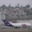

In [31]:
#Display the first image
print(dataset_train[0]["img"].size)
dataset_train[0]["img"]

In [32]:
#display the label(which is int) and the class name (in str) for first img
dataset_train[0]["label"], labels.names[dataset_train[0]["label"]]

(0, 'airplane')

In [33]:
#Loading/Downloading Vision Transformer Pretrained Net that is trained on ImageNet 21K Dataset
#This uses 16x16 patches of 224x224 image
#This model is from huggingface library
#We use this pretrained model to extract features for our image dataset

from transformers import ViTFeatureExtractor

model_name_or_path = "google/vit-base-patch16-224-in21k"
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [34]:
#display the config of Feature extractor
#FE kind of preprocess our input images to network requirements and also sepcifies the processor type
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [35]:
#Lets see the feature representation for our first image using the VIT feature extractor
example = feature_extractor(dataset_train[0]["img"],
                            return_tensors="pt")
example

{'pixel_values': tensor([[[[ 0.3961,  0.3961,  0.3961,  ...,  0.2941,  0.2941,  0.2941],
          [ 0.3961,  0.3961,  0.3961,  ...,  0.2941,  0.2941,  0.2941],
          [ 0.3961,  0.3961,  0.3961,  ...,  0.2941,  0.2941,  0.2941],
          ...,
          [-0.1922, -0.1922, -0.1922,  ..., -0.2863, -0.2863, -0.2863],
          [-0.1922, -0.1922, -0.1922,  ..., -0.2863, -0.2863, -0.2863],
          [-0.1922, -0.1922, -0.1922,  ..., -0.2863, -0.2863, -0.2863]],

         [[ 0.3804,  0.3804,  0.3804,  ...,  0.2784,  0.2784,  0.2784],
          [ 0.3804,  0.3804,  0.3804,  ...,  0.2784,  0.2784,  0.2784],
          [ 0.3804,  0.3804,  0.3804,  ...,  0.2784,  0.2784,  0.2784],
          ...,
          [-0.2471, -0.2471, -0.2471,  ..., -0.3412, -0.3412, -0.3412],
          [-0.2471, -0.2471, -0.2471,  ..., -0.3412, -0.3412, -0.3412],
          [-0.2471, -0.2471, -0.2471,  ..., -0.3412, -0.3412, -0.3412]],

         [[ 0.4824,  0.4824,  0.4824,  ...,  0.3647,  0.3647,  0.3647],
          [ 0

In [37]:
example["pixel_values"].shape #same size as resize input image (3, 224, 224) channel first, along with batch dimension

torch.Size([1, 3, 224, 224])

In [38]:
#Lets fine the ViT transformer model with our data using the feature representations of our images using Vit
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [43]:
#Now set up the same preprocess part and feature extraction as we did above for demo using single image to actually do for reall for batch of images

def preprocess(batch):
    #take batch of PIL Images and preprocess them and extract features
    inputs = feature_extractor(batch["img"], return_tensors="pt")
    #include the labels
    inputs["label"] = batch["label"]
    return inputs


In [44]:
#apply the preprocessing transformations the training dataset
prepared_train = dataset_train.with_transform(preprocess)

#transform the testing dataset
prepared_test = dataset_test.with_transform(preprocess)

## **Model Finetuning**

    We need to define args to the model like train, test datasets, feature extractor, model, collate function, eval metric, other training args

In [45]:
#Collate function is useful when  dealing with lots of data.
#Batches are lists of dictionaries, so collate will help us create batch tensors
#It return batch data in dictionary format
def collate_fn(batch):
    return{
        "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
        "labels": torch.tensor([x["label"] for x in batch])
    }

In [46]:
#Eval function
import numpy as np
from datasets import load_metric

#accuracy metric
metric = load_metric("accuracy")

def compute_metric(p):
    return metric.compute(
        predictions=np.argmax(p.predictions, axis=1),
        references=p.label_ids
    )

In [47]:
#Training via Finetuning
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./cifar",
    per_device_train_batch_size=16,
    evaluation_strategy="steps",
    num_train_epochs=4,
    save_steps=100,
    eval_steps=100,
    logging_steps=10,
    learning_rate=2e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    load_best_model_at_end=True
)

In [48]:
#Initialize the pretrained model with our classification head of num_classes we have i.e 10
#we ll also have id2label and label2id mappings to have human readable labels in the Hub widget

from transformers import ViTForImageClassification

labels = dataset_train.features["label"].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels)
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [49]:
#moving the model to GPU
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [50]:
#Now, all instances can be passed to Trainer

from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metric,
    train_dataset=prepared_train,
    eval_dataset=prepared_test,
    tokenizer=feature_extractor,
)

In [ ]:
#Train the model
train_results = trainer.train()

#save tokenizer with the model
trainer.save_model()

#log and also save the training accuracy metric
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)

#save the trainer state
trainer.save_state()

Step,Training Loss,Validation Loss,Accuracy
100,0.323600,0.469281,0.883900
200,0.349100,0.317912,0.918600
300,0.319400,0.290000,0.919600
400,0.429700,0.417170,0.885300
500,0.453300,0.330900,0.903100
600,0.217300,0.270006,0.919500
700,0.285900,0.231009,0.932200
800,0.382800,0.328023,0.904200
900,0.279100,0.252272,0.928200
1000,0.345100,0.330839,0.901400


In [ ]:
#Model Evaluation
metrics = trainer.evaluate(prepared_test)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)